In [60]:
# Determine bounds
from osgeo import gdal, ogr, osr
from osgeo_utils import gdal_calc
import numpy as np
import xarray as xr
import rioxarray
import os
import rasterio

ogr.UseExceptions()

ds = xr.open_dataset("../mort_datasets/westmort.nc")
bounds = ds.rio.bounds()
shape = ds.mortality.shape

In [61]:
bounds

(-13896215.609, 3672302.4189999998, -11536215.609, 6280302.419)

In [5]:
# Dissolve damage polygons by year
!ogr2ogr damage_dissolve.gpkg ../data_working/damage_merged.gdb -dialect sqlite -sql "SELECT ST_Union(SHAPE), SURVEY_YEAR FROM merged GROUP BY SURVEY_YEAR" 

GEOS error: TopologyException: side location conflict at -13199510.873425175 4313176.8289620252. This can occur if the input geometry is invalid.


In [16]:
dissolve_ds = gdal.OpenEx("damage_dissolve.gpkg")
dissolve_lyr = dissolve_ds.GetLayerByIndex(0)
unique_years = dissolve_ds.ExecuteSQL("SELECT DISTINCT SURVEY_YEAR FROM 'SELECT'")
unique_years = [r.GetField(0) for r in unique_years]
print(unique_years)

[1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [54]:
from tempfile import TemporaryDirectory
import subprocess
from tqdm.autonotebook import tqdm

FINE_RES=100
COARSE_RES=4000
OUT_SREF="EPSG:3857"

outputs = {}

for yr in (pbar := tqdm(range(2001, max(unique_years)-1))):
    # Make a fresh tempdir every time so there is no layer interference
    with TemporaryDirectory() as tdir:
        # Extract features of interest
        pbar.set_description("Extract features...")
        subprocess.check_call((
            "ogr2ogr",
            f"{tdir}/temp_dissolve_{yr+1}.gpkg",
            "damage_dissolve.gpkg",
            "-dialect", "sqlite",
            "-sql", f"SELECT * FROM \'SELECT\' WHERE SURVEY_YEAR = {yr+1}",
            "-of", "GPKG",
            "-nlt", "GEOMETRYCOLLECTION"
        ))
    
        subprocess.check_call((
            "ogr2ogr",
            f"{tdir}/temp_dissolve_{yr}.gpkg",
            "damage_dissolve.gpkg",
            "-dialect", "sqlite",
            "-sql", f"SELECT * FROM \'SELECT\' WHERE SURVEY_YEAR = {yr}",
            "-of", "GPKG",
            "-nlt", "GEOMETRYCOLLECTION"
        ))
    
        # Compute union
        pbar.set_description("Union...")
        subprocess.check_call((
            "ogr_layer_algebra", "Union",
            "-input_ds",  f"{tdir}/temp_dissolve_{yr+1}.gpkg",
            "-method_ds", f"{tdir}/temp_dissolve_{yr  }.gpkg",
            "-output_ds", f"{tdir}/union.gpkg",
            "-output_lyr", "union",
            "-input_fields", "ALL",
            "-method_fields", "NONE",
            "-f", "GPKG",
            "-nlt", "GEOMETRYCOLLECTION"
        ))
        
        # Compute intersection
        pbar.set_description("Intersection...")
        subprocess.check_call((
            "ogr_layer_algebra", "Intersection",
            "-input_ds",  f"{tdir}/temp_dissolve_{yr+1}.gpkg",
            "-method_ds", f"{tdir}/temp_dissolve_{yr  }.gpkg",
            "-output_ds", f"{tdir}/intersection.gpkg",
            "-output_lyr", "intersection",
            "-input_fields", "ALL",
            "-method_fields", "NONE",
            "-f", "GPKG",
            "-nlt", "GEOMETRYCOLLECTION"
        ))
    
        # Fine rasterize
        pbar.set_description("Fine burn...")
        gdal.Rasterize(
            f"{tdir}/temp_union_burn_fine_{yr}.tif",
            f"{tdir}/union.gpkg",
            burnValues=[100],
            initValues=[0],
            xRes=FINE_RES,
            yRes=FINE_RES,
            allTouched=True,
            outputBounds=bounds,
            outputSRS=OUT_SREF,
            creationOptions=["BIGTIFF=YES", "COMPRESS=DEFLATE"],
            outputType=gdal.GDT_Int8,
        )
    
        gdal.Rasterize(
            f"{tdir}/temp_intersection_burn_fine_{yr}.tif",
            f"{tdir}/intersection.gpkg",
            burnValues=[100],
            initValues=[0],
            xRes=FINE_RES,
            yRes=FINE_RES,
            allTouched=True,
            outputBounds=bounds,
            outputSRS=OUT_SREF,
            creationOptions=["BIGTIFF=YES", "COMPRESS=DEFLATE"],
            outputType=gdal.GDT_Int8,
        )
    
        # Resample to 4km
        pbar.set_description("Resampling...")
        gdal.Warp(
            f"{tdir}/temp_union_burn_coarse_{yr}.tif",
            f"{tdir}/temp_union_burn_fine_{yr}.tif",
            format="GTiff",
            xRes=COARSE_RES,
            yRes=COARSE_RES,
            dstSRS=OUT_SREF,
            creationOptions=["BIGTIFF=YES", "COMPRESS=DEFLATE"],
            outputType=gdal.GDT_Int16,
            resampleAlg=gdal.GRA_Average,
        )
    
        gdal.Warp(
            f"{tdir}/temp_intersection_burn_coarse_{yr}.tif",
            f"{tdir}/temp_intersection_burn_fine_{yr}.tif",
            format="GTiff",
            xRes=COARSE_RES,
            yRes=COARSE_RES,
            dstSRS=OUT_SREF,
            creationOptions=["BIGTIFF=YES", "COMPRESS=DEFLATE"],
            outputType=gdal.GDT_Int16,
            resampleAlg=gdal.GRA_Average,
        )
    
        # Assign nodata
        subprocess.call((
            "gdal_edit",
            "-a_nodata", "0",
            f"{tdir}/temp_union_burn_coarse_{yr}.tif"
        ))
    
        pbar.set_description("Computing IoU...")
        gdal_calc.Calc(
            calc="np.where(b > 0, (100 * a) / b, -1)",
            user_namespace={"np": np},
            NoDataValue=-1,
            a=f"{tdir}/temp_intersection_burn_coarse_{yr}.tif",
            b=f"{tdir}/temp_union_burn_coarse_{yr}.tif",
            outfile=f"{tdir}/iou_{yr}.tif",
            type="Int8",
            overwrite=True,
            creation_options=["BIGTIFF=YES", "COMPRESS=DEFLATE"]
        )
    
        with rasterio.open(f"{tdir}/iou_{yr}.tif") as iou:
            arr = iou.read()
    
        outputs[yr] = arr


  0%|          | 0/22 [00:00<?, ?it/s]

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide
Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer union of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type GEOMETRYCOLLECTION is inserted into layer intersection of geometry type MULTIPOLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<string>:1: RuntimeWarning: invalid value encountered in divide


In [62]:
xarrs = [
    xr.DataArray(
        data=val,
        dims=("time", "y", "x"),
        coords={"x": ds.x, "y": ds.y, "time": [key]}
    ) for key, val in outputs.items()
]

In [70]:
iou = xr.concat(xarrs, "time")
iou = iou.where(iou != -1)
iou = iou.rename("iou")
iou

<xarray.DataArray 'iou' (time: 22, y: 652, x: 590)> Size: 34MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time     (time) int64 176B 2001 2002 2003 2004 2005 ... 2019 2020 2021 2022

(array([6.0382e+04, 7.3090e+03, 2.4890e+03, 1.0940e+03, 4.3300e+02,
        1.9100e+02, 1.0200e+02, 3.2000e+01, 1.4000e+01, 1.3000e+01]),
 array([ 0.        ,  5.04444408, 10.08888817, 15.13333321, 20.17777634,
        25.22222137, 30.26666641, 35.31111145, 40.35555267, 45.39999771,
        50.44444275]),
 <BarContainer object of 10 artists>)

Exception ignored in: <built-in function delete_Dataset>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/_api/__init__.py", line 124, in check_in_list
    for key, val in kwargs.items():
RuntimeError: Error occurred in GDALClose()


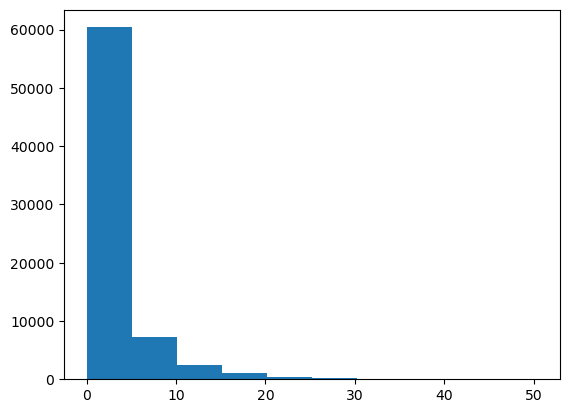

In [68]:
iou.mean(dim="time").plot.hist()

In [71]:
iou.to_netcdf("../mort_datasets/westmort_iou.nc", encoding=dict(iou={"dtype": "int8", "_FillValue": -128}))